Loaded 420 samples.
Training samples: 336, Testing samples: 84
Resampled training samples: 336
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200, 'subsample': 0.8}
                     precision    recall  f1-score   support

            Healthy       0.81      0.69      0.74        42
Parkinson Diagnosed       0.73      0.83      0.78        42

           accuracy                           0.76        84
          macro avg       0.77      0.76      0.76        84
       weighted avg       0.77      0.76      0.76        84



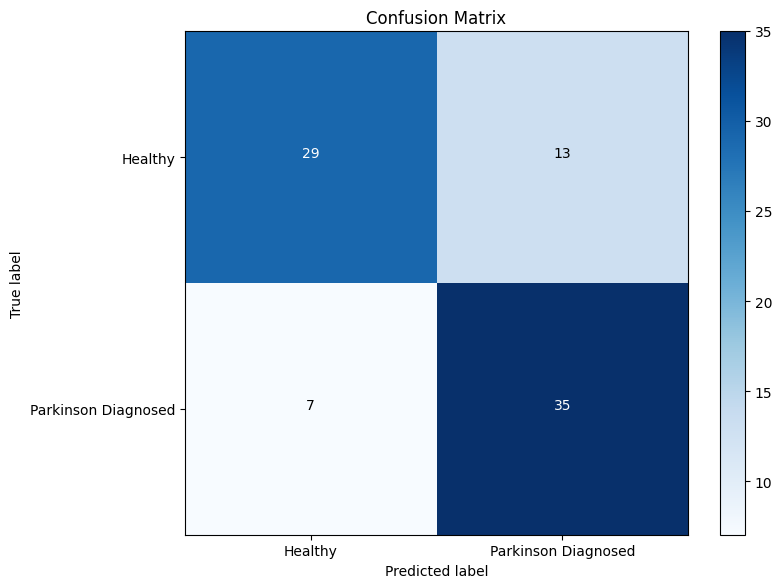

Model, scaler, and selector saved.


In [39]:
# Import Libraries
import os
import numpy as np
import librosa
import joblib
import warnings
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Suppress warnings from librosa
warnings.filterwarnings('ignore')

# Data Augmentation Function with Corrected pitch_shift Calls
def augment_data(y, sr):
    augmented_data = []
    # Original data
    augmented_data.append(y)
    # Noise injection
    noise = np.random.randn(len(y))
    augmented_data.append(y + 0.005 * noise)
    # Pitch shifting (pass sr as a keyword argument)
    augmented_data.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=2))
    augmented_data.append(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2))
    # Time stretching (ensure y is long enough)
    if len(y) > 22050:  # At least 0.5 seconds at 44.1kHz
        augmented_data.append(librosa.effects.time_stretch(y, rate=1.1))
        augmented_data.append(librosa.effects.time_stretch(y, rate=0.9))
    return augmented_data

# Enhanced Feature Extraction Function
def extract_features(y, sr):
    # Ensure y is not empty and has sufficient length
    if y is None or y.size == 0 or len(y) < 2048:
        return None

    # Initialize feature list
    features = []

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = mfccs.mean(axis=1)
    features.extend(mfcc_mean)

    # Zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = zcr.mean()
    features.append(zcr_mean)

    # Spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = spectral_centroid.mean()
    features.append(spectral_centroid_mean)

    # Spectral rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spectral_rolloff_mean = spectral_rolloff.mean()
    features.append(spectral_rolloff_mean)

    # Spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = spectral_bandwidth.mean()
    features.append(spectral_bandwidth_mean)

    # Chroma features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = chroma_stft.mean(axis=1)
    features.extend(chroma_stft_mean)

    # Root Mean Square Energy
    rmse = librosa.feature.rms(y=y)
    rmse_mean = rmse.mean()
    features.append(rmse_mean)

    # Tonnetz
    try:
        y_harmonic = librosa.effects.harmonic(y)
        chroma = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
        tonnetz = librosa.feature.tonnetz(chroma=chroma)
        tonnetz_mean = tonnetz.mean(axis=1)
    except:
        tonnetz_mean = np.zeros(6)
    features.extend(tonnetz_mean)

    # Fundamental frequency (pitch)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitches = pitches[magnitudes > np.median(magnitudes)]
    pitch_mean = pitches.mean() if pitches.size > 0 else 0
    features.append(pitch_mean)

    # Convert feature list to numpy array
    features = np.array(features)

    return features

# Load Dataset Function with Data Augmentation
def load_dataset(folder):
    data = []
    labels = []
    class_labels = {'HC_AH': 0, 'PD_AH': 1}  # Update with your actual class labels

    for class_dir in os.listdir(folder):
        class_path = os.path.join(folder, class_dir)
        if not os.path.isdir(class_path):
            continue

        label = class_labels.get(class_dir)
        if label is None:
            continue

        for filename in os.listdir(class_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(class_path, filename)
                y, sr = librosa.load(file_path, sr=None)
                augmented_signals = augment_data(y, sr)
                for y_aug in augmented_signals:
                    features = extract_features(y_aug, sr)
                    if features is not None:
                        data.append(features)
                        labels.append(label)
    return np.array(data), np.array(labels)

# Load Dataset
dataset_path = 'dataset'  # Update with your dataset path
data, labels = load_dataset(dataset_path)
print(f"Loaded {len(data)} samples.")

# Ensure there are samples to proceed
if len(data) == 0:
    print("No data available after feature extraction. Please check your dataset.")
    exit()

# Split Dataset with Stratification
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training samples: {len(X_train_resampled)}")

# Scale Features
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Feature Selection
selector = SelectKBest(score_func=f_classif, k=30)  # Adjust 'k' as needed
X_train_resampled = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test = selector.transform(X_test)

# Model Training with Cross-Validation and Hyperparameter Tuning
model = GradientBoostingClassifier(random_state=42)

# Hyperparameter Grid for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Cross-validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1
)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best model from grid search
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the Model
y_pred = best_model.predict(X_test)
print(
    classification_report(
        y_test, y_pred, target_names=['Healthy', 'Parkinson Diagnosed']
    )
)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(['Healthy', 'Parkinson Diagnosed']))
plt.xticks(tick_marks, ['Healthy', 'Parkinson Diagnosed'])
plt.yticks(tick_marks, ['Healthy', 'Parkinson Diagnosed'])

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(
        j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Save the Model, Scaler, and Selector
joblib.dump(best_model, 'gradient_boosting_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'selector.pkl')  # Save the feature selector
print("Model, scaler, and selector saved.")


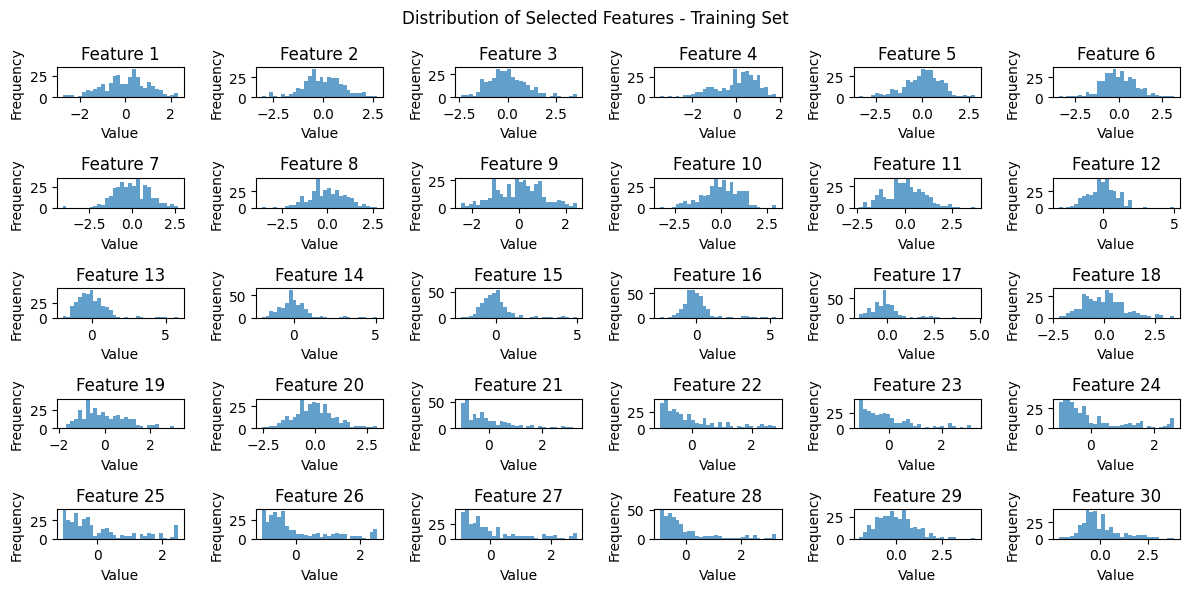

In [40]:
# Visualize the distribution of selected features
def plot_feature_distribution(X, title):
    plt.figure(figsize=(12, 6))
    for i in range(X.shape[1]):
        plt.subplot(5, 6, i + 1)  # Adjust number of subplots based on features
        plt.hist(X[:, i], bins=30, alpha=0.7)
        plt.title(f'Feature {i + 1}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_feature_distribution(X_train_resampled, "Distribution of Selected Features - Training Set")


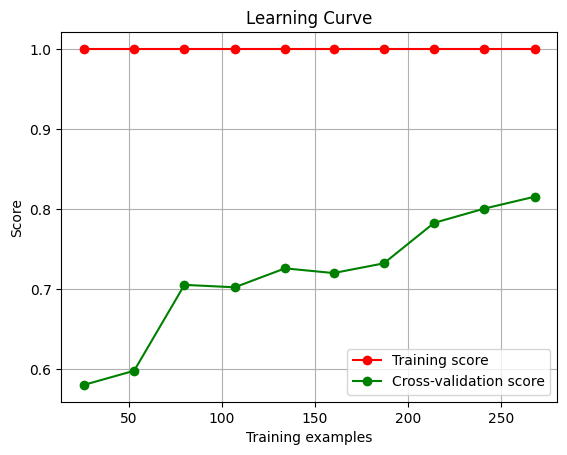

In [41]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=-1,
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

plot_learning_curve(best_model, X_train_resampled, y_train_resampled)


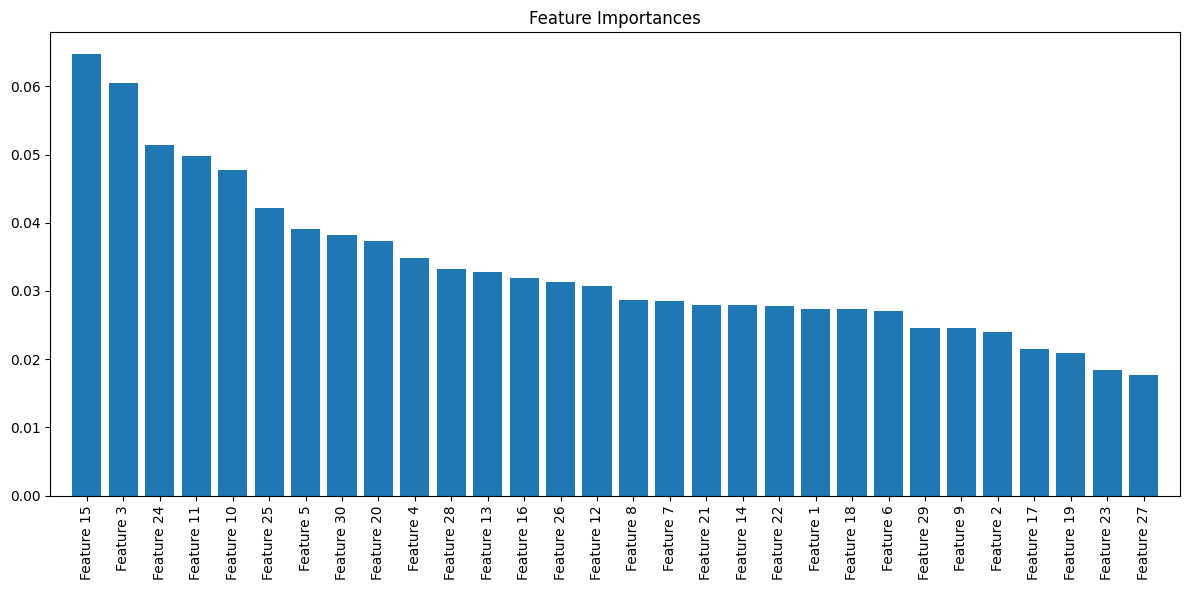

In [42]:
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

# Get feature names based on the selected features
feature_names = [f'Feature {i+1}' for i in range(X_train_resampled.shape[1])]
plot_feature_importance(best_model, feature_names)


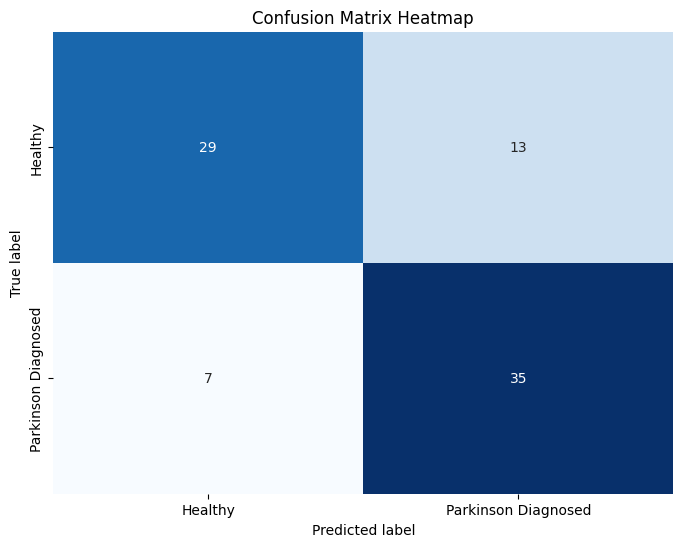

In [43]:
import seaborn as sns

def plot_confusion_matrix_heatmap(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Healthy', 'Parkinson Diagnosed'],
                yticklabels=['Healthy', 'Parkinson Diagnosed'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

plot_confusion_matrix_heatmap(cm)


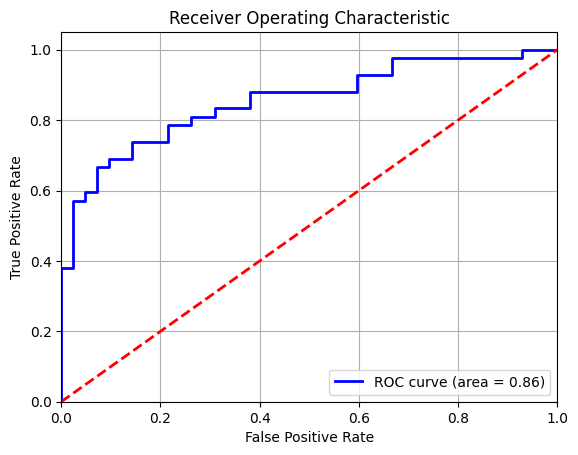

In [44]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_scores):
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Get the predicted probabilities
y_scores = best_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_scores)
